# Notebook to setup the radcalnet_oc package

In [29]:

import os, shutil
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

plt.rcParams.update({'font.size': 18, 'axes.labelsize': 22})
import numpy as np
import xarray as xr
import pandas as pd

import radcalnet_oc as radoc
from radcalnet_oc import acutils
print(f'-radcalnet_oc: {radoc.__version__}')


-radcalnet_oc: 0.0.1


## Load look-up tables

In [30]:
lut= radoc.LUT()
lut.load_auxiliary_data()
lut.gas_lut

<xarray.Dataset> Size: 2MB
Dimensions:  (wl: 21687)
Coordinates:
  * wl       (wl) float64 173kB 349.9 350.1 350.3 ... 2.599e+03 2.6e+03
Data variables:
    ch4      (wl) float64 173kB ...
    co       (wl) float64 173kB ...
    co2      (wl) float64 173kB ...
    h2o      (wl) float64 173kB ...
    n2o      (wl) float64 173kB ...
    no2      (wl) float64 173kB ...
    o2       (wl) float64 173kB ...
    o3       (wl) float64 173kB ...
    o4       (wl) float64 173kB ...
Attributes:
    description:           Absorption optical thickness of some atmospheric g...
    atmospheric pressure:  1000 hPa

## Set total column integrated concentration of absorbing gases and zenith angles (sza:sun and vza:viewing)

In [47]:
48*2.69/6.02


21.448504983388705

In [49]:

sza=40
vza=0
pressure=1000

#water vapor in cm
tpw_cm=2.6

#ozone in dobson
to3_du=300 

#NO2 (micromol.m-2)
tcno2_micmol_m2=100

# ch4 in kg.m-2
tcch4= 1e-2

# unit conversion
# tcwv cm into kg.m-2
tcwv=tpw_cm*10 

# conversion O3 du to kg.m-2
tco3=to3_du *2.14485e-5

# conversion NO2 micromol.m-2 into kg.m-2
tcno2=tcno2_micmol_m2*46.0e-9
tcno2

4.6e-06

In [50]:
6.4286e-3/300

2.1428666666666667e-05

## Compute spectral transmittances

In [60]:
gas_trans = radoc.GaseousTransmittance(lut.gas_lut)
gas_trans.air_mass=1./np.cos(np.radians(sza))+1./np.cos(np.radians(vza))
gas_trans.pressure=pressure
gas_trans.gas_tc['h2o'] = tcwv
gas_trans.gas_tc['o3'] = tco3
gas_trans.gas_tc['ch4'] = tcch4
gas_trans.gas_tc['no2'] = tcno2

# set total transmittance values
gas_trans.coef_abs_scat['h2o'] = 0.5
gas_trans.coef_abs_scat['ch4'] = 0.65
Ttot=gas_trans.get_gaseous_transmittance()

# set total transmittance values
gas_trans.coef_abs_scat['h2o'] = 1
gas_trans.coef_abs_scat['ch4'] = 1
Ttot2=gas_trans.get_gaseous_transmittance()

## Plot results

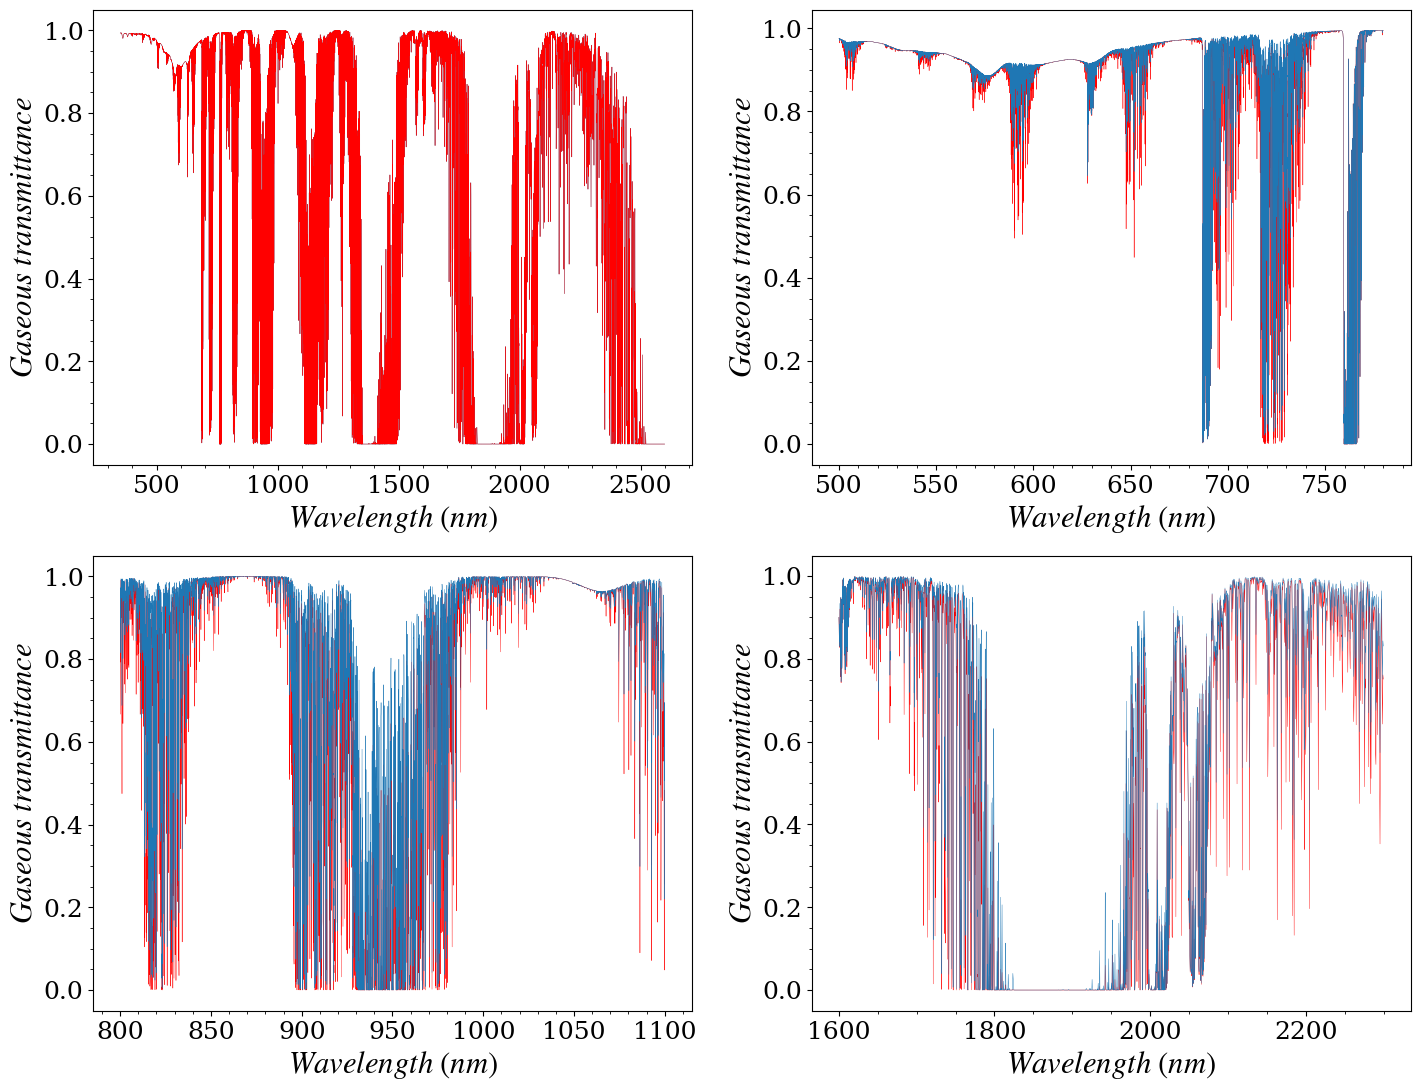

In [61]:


fig,axs = plt.subplots(2,2,figsize=(17,13))
axs=axs.ravel()

Ttot.plot(lw=0.3,ax=axs[0])
Ttot.plot(lw=0.3,ax=axs[0],c='r')

wl_range=slice(500,780)
Ttot2.sel(wl=wl_range).plot(lw=0.3,ax=axs[1],c='r')
Ttot.sel(wl=wl_range).plot(lw=0.3,ax=axs[1],label='Tg')
wl_range=slice(800,1100)
Ttot2.sel(wl=wl_range).plot(lw=0.3,ax=axs[2],c='r')
Ttot.sel(wl=wl_range).plot(lw=0.3,ax=axs[2],label='Tg')
wl_range=slice(1600,2300)
Ttot2.sel(wl=wl_range).plot(lw=0.3,ax=axs[3],c='r')
Ttot.sel(wl=wl_range).plot(lw=0.3,ax=axs[3],label='Tg')

for ax in  axs:
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.set_ylabel(r'$Gaseous\ transmittance$')
    ax.minorticks_on()
    #ax.semilogy()

#plt.semilogy()

## Check impact of the spectral resolution (sensor-like)

Spectral resolution is defined by the number (central wavelength: central_wl) and width (gaussian distribution) of spectral bands recorded. The gaussian distribution are computed from the full width at half maximum fwhm given in nanometers.

/tmp/ipykernel_681276/1115990838.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


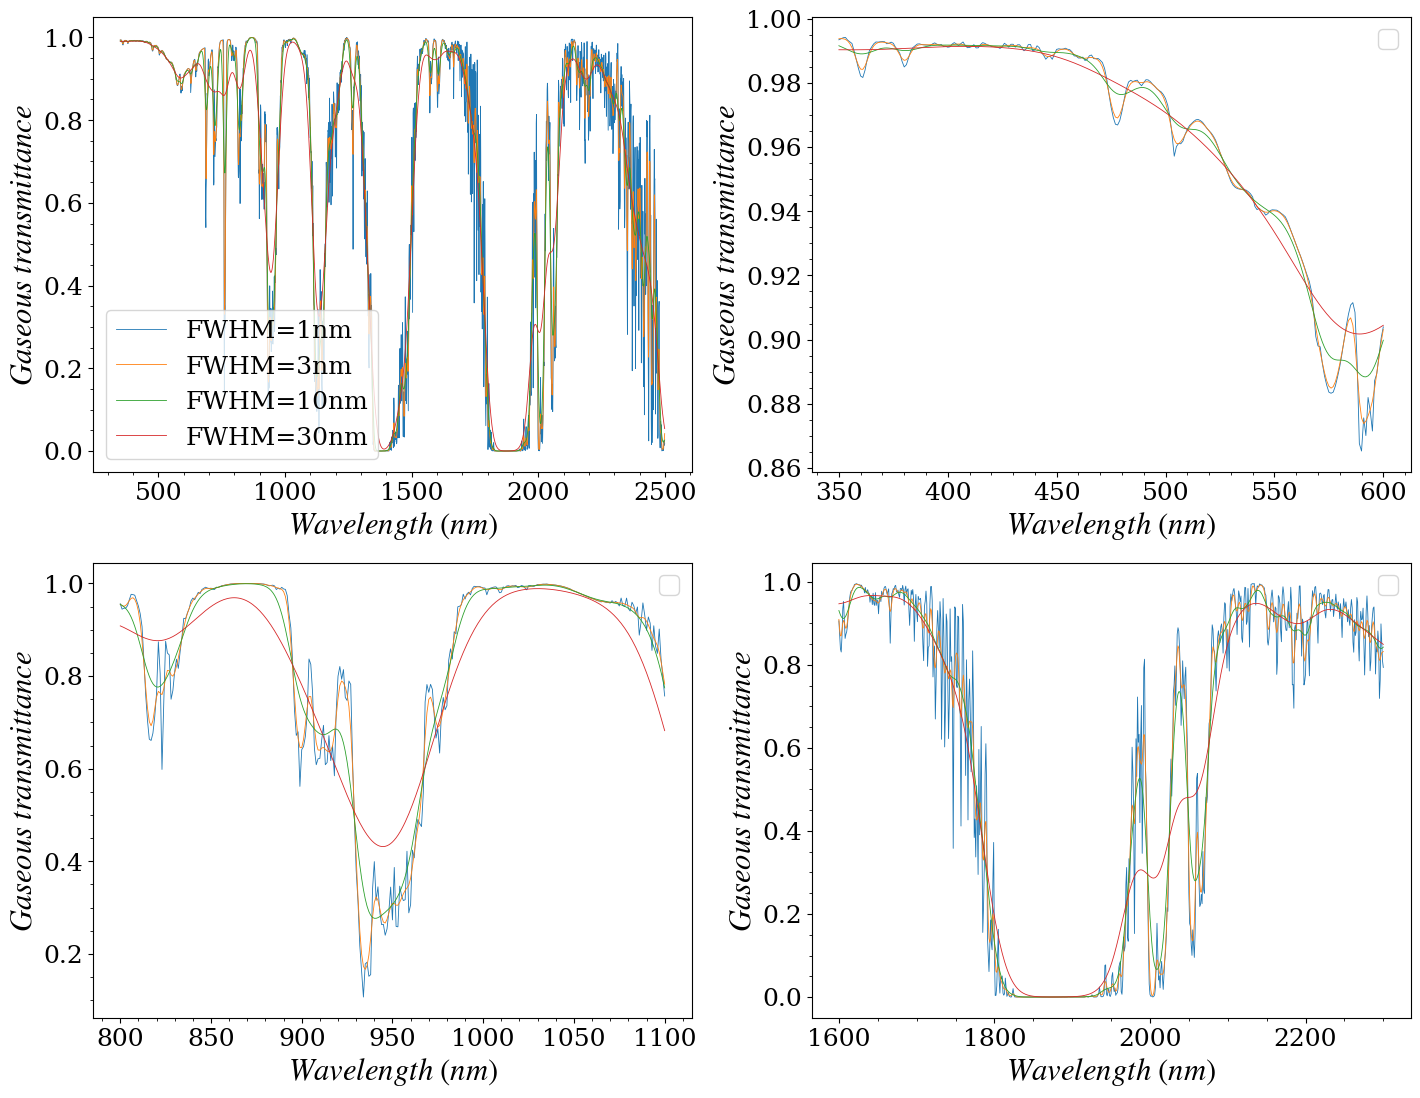

In [62]:

spectral_res=1
central_wl=np.arange(350,2500,spectral_res)
wl_range=slice(500,780)

signal = Ttot
wl_signal = signal.wl.values

fig,axs = plt.subplots(2,2,figsize=(17,13))
axs=axs.ravel()

for fwhm in [1,3,10,30]:    
    spectral=radoc.Spectral(central_wl,fwhm)
    Tg = spectral.convolve(signal)
    Tg.plot(lw=0.6,label='FWHM='+str(fwhm)+'nm',ax=axs[0])
    
    wl_range=slice(350,600)
    Tg.sel(wl=wl_range).plot(lw=0.6,ax=axs[1])
    
    wl_range=slice(800,1100)
    Tg.sel(wl=wl_range).plot(lw=0.6,ax=axs[2])
    wl_range=slice(1600,2300)
    Tg.sel(wl=wl_range).plot(lw=0.6,ax=axs[3])
    
for ax in axs:
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.set_ylabel(r'$Gaseous\ transmittance$')
    ax.minorticks_on()  
    ax.legend()

[]

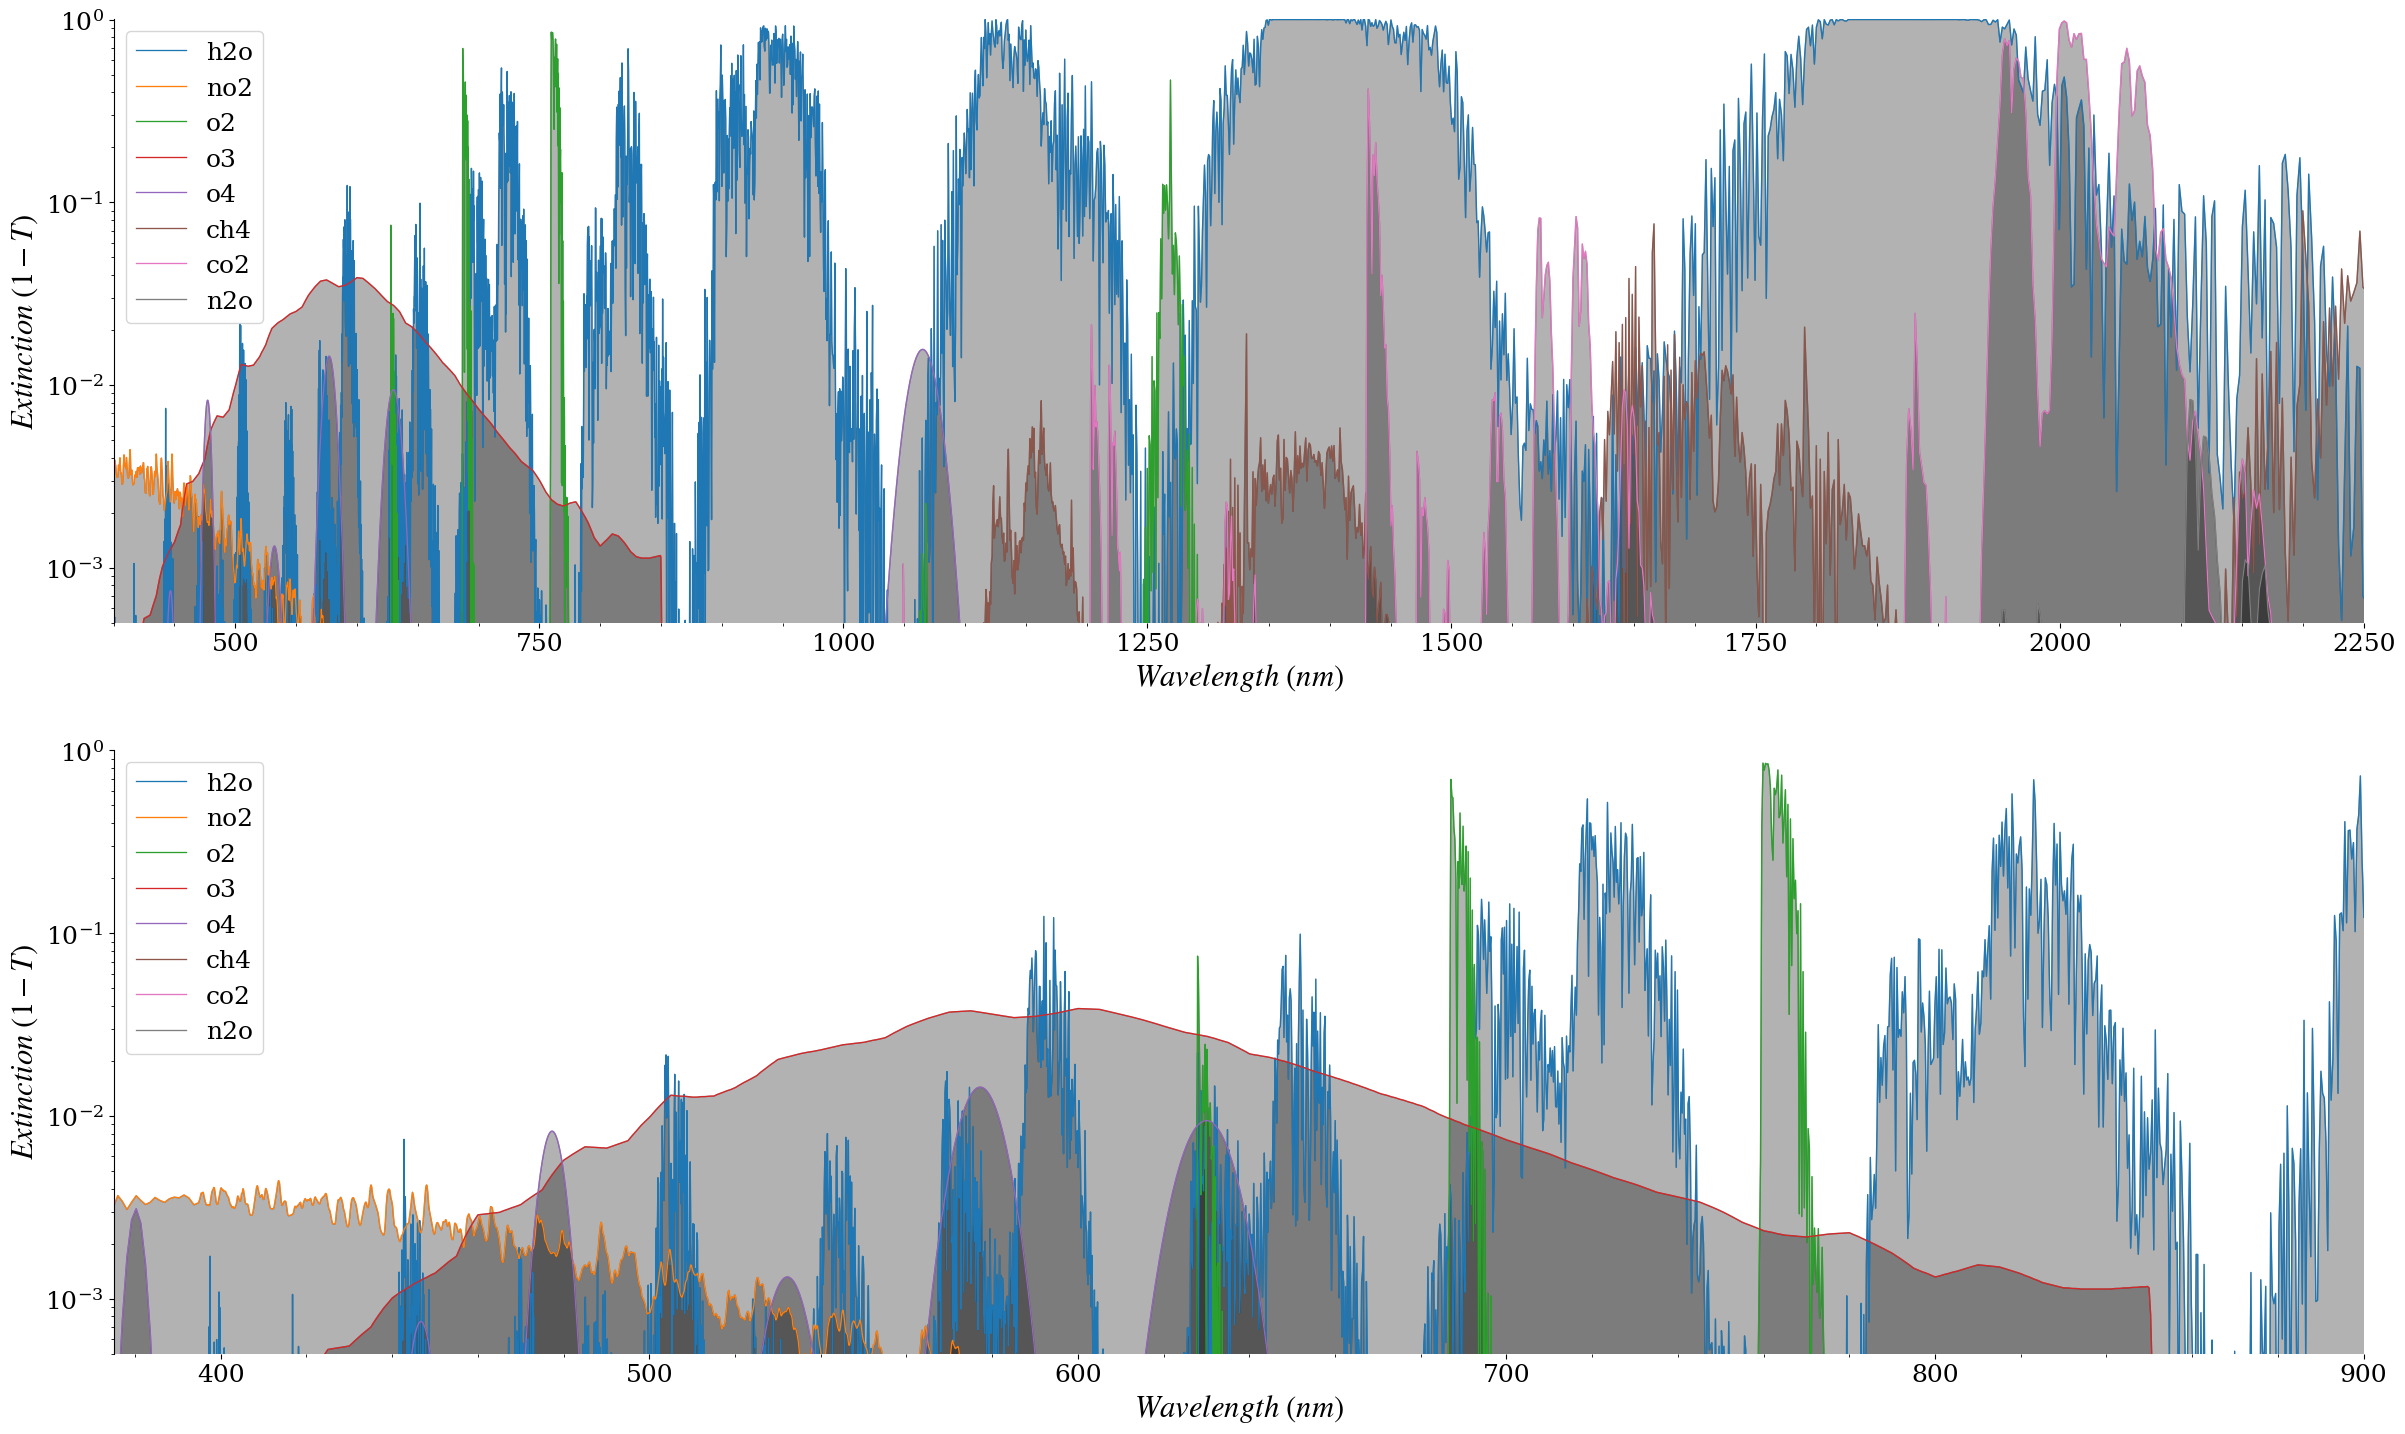

In [54]:
M=1./np.cos(np.radians(sza))+1./np.cos(np.radians(vza))
variable='o4'
variables=['h2o','no2','o2','o3','o4','ch4','co2','n2o']
conc={'ch4':tcch4,'co':1,'co2':1,
      'h2o':tcwv,'n2o':1,'no2':tcno2,
      'o2':1,'o3':tco3,'o4':1}



fig, axs = plt.subplots(nrows=2, sharey=True, figsize=(25, 15))
fig.subplots_adjust(bottom=0.05, top=0.94, left=0.05, right=0.95, hspace=0.21, wspace=0.025)
for iax in range(2):
    for i, variable in enumerate(variables):
        abs_ot = gas_trans.gas_lut[variable]*conc[variable]
        Tg = np.exp(-abs_ot).coarsen(wl=5,boundary='pad').mean()
        axs[iax].minorticks_on()
        axs[iax].spines[['right', 'bottom', 'top']].set_visible(False)
        axs[iax].fill_between(Tg.wl,
                              1 - Tg, color='k', alpha=0.3)
        axs[iax].plot(Tg.wl,
                      1 - Tg,  lw=0.95,label=variable)
   
    axs[iax].set_xlabel(r'$Wavelength\ (nm)$')
    axs[iax].legend()



for i in range(2):
    axs[i].set_ylabel(r'$Extinction\ (1-T)$')

axs[0].set_xlim([400, 2250])
axs[1].set_xlim([375, 900])
axs[0].set_ylim([0.0005, 1.01])
axs[0].semilogy()